In [2]:
import pickle
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from scipy import stats
import os 
from copy import deepcopy
import re
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
import pyLDAvis
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as vis_gensim
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS, WordCloud

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/timo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/timo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/timo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/timo/anaconda3/envs/pytorch/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/timo/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavi

# Topic Modeling
Analysis of particpant's self report of learned rules. I look for common themes within each task/domain

In [3]:
# set a few parameters 
working_dir = os.getcwd()
data_dir = working_dir + '/data/'
domains = ['animals','vehicles']
curricula = ['blocked','interleaved']
rules = ['resp_ruleSpeed','resp_ruleSize']

# load data 
with open('animals_vehicles_pilot.pkl','rb') as f:
    alldata = pickle.load(f)

In [4]:
# inspect raw data
alldata['animals']['blocked']['resp_ruleSpeed']

['whether or not they were a jungle animal and if they could swim ',
 'For the blue store, I figured that it was mainly smaller animals and bugs that received higher points, although there were some exceptions such as the giraffe and the whale. ',
 "couldn't figure out the rule for this store just had to memorise",
 'i honestly just went by memory from the practice rounds and remembered specific animals, i tried to find patterns but every time i thought i found one it was wrong',
 'small animals',
 'Appeared to be a perceived level of attractiveness',
 'a lot of the times lions were favoured along with horses. most of the time giraffes were favoured. house animals like hamster and outdoor animals like squireels where neutral. some shops favoured sea animals more than land',
 'If it could fly',
 'Not farm animals',
 'no elephants, fluffy animals (bunny), some insects were rewarding (bees) but generally accepting of most insects. Most large zoe animals (tiger, giraffee), not bats. Some w

## Preprocessing
preprocessing pipeline for NLP

In [5]:
def remove_stopwords(string,stopwords):
    '''
    removes stopwords from string
    '''
    # tokenise
    string = word_tokenize(string)
    # only keep non stopwords
    string = ' '.join([w for w in string if not w in stopwords])
    return string


def lemmatise(string):
    '''
    lemmatises words in sentence
    '''
    # tokenise the sentence
    string = word_tokenize(string)
    # lemmatise each word in sentence
    lemmatiser = WordNetLemmatizer()
    string = [lemmatiser.lemmatize(w,pos='n') for w in string]
    string = [lemmatiser.lemmatize(w,pos='v') for w in string]
    string = [lemmatiser.lemmatize(w,pos='a') for w in string]
    string = ' '.join(string)
    return string


def cleanup_txtresponses(alldata,whichstopwords='topicmodel'):
    domains = ['animals','vehicles']
    curricula = ['blocked','interleaved']
    rules = ['resp_ruleSpeed','resp_ruleSize']
    alldata2 = deepcopy(alldata)
    # stopwords: some standard stopwords of english language
    # sws = set(stopwords.words('english'))
    sws = set(STOPWORDS)
    # stopwords: task specific stopwords
    if whichstopwords=='wordcloud':
        sws.update(['animal','vehicle','orange','blue','store','think','reward','rule','accept','reject','remember','point',':','&',',','.','!','?','/','-','(',')',"n't",'=',"'","'m","'s",'+','wa'])
    elif whichstopwords=='topicmodel':
        sws.update([':','&',',','.','!','?','/','-','(',')',"n't",'=',"'","'m","'s",'+','wa'])

    for dom in domains:
        for cur in curricula:
            for rule in rules:
                for idx,string in enumerate(alldata[dom][cur][rule]):
                    # remove leading/trialing white space, remove newline escape char, all lower case
                    string =  string.strip().replace('\n',' ').lower()
                    string = string.replace('/',' ')
                    # lemmatisation
                    string = lemmatise(string)
                    # remove stopwords
                    string = remove_stopwords(string,sws)
                    # tokenisation
                    string = word_tokenize(string)
                    # remove leading hyphen
                    string = [re.sub('^-','',w) for w in string]
                    # remove trailing hyphen
                    string = [re.sub('-$','',w) for w in string]
                    # remove sequence of fullstops (of any length)
                    string = [re.sub('([.])*','',w) for w in string]
                    # remove empty strings
                    while "" in string:
                        string.remove("")
                    # store cleaned string in list
                    alldata2[dom][cur][rule][idx] = string
                    
    return alldata2


with open('animals_vehicles_pilot.pkl','rb') as f:
    alldata = pickle.load(f)
# clean up text responses 
alldata_wc = cleanup_txtresponses(alldata,whichstopwords='wordcloud')
alldata_cleaned = cleanup_txtresponses(alldata,whichstopwords='topicmodel')

## Word Cloud and Word Counts
Let's have a look at dominant terms for each task

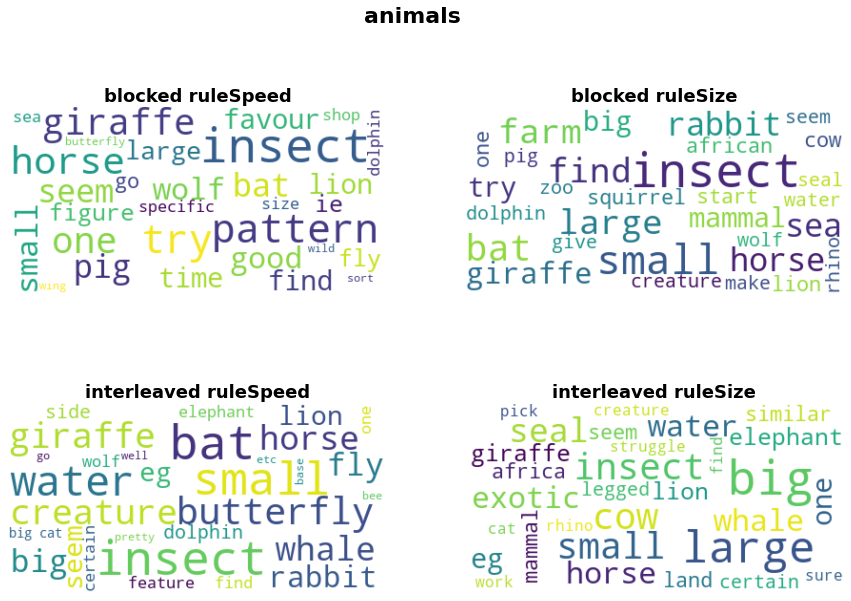

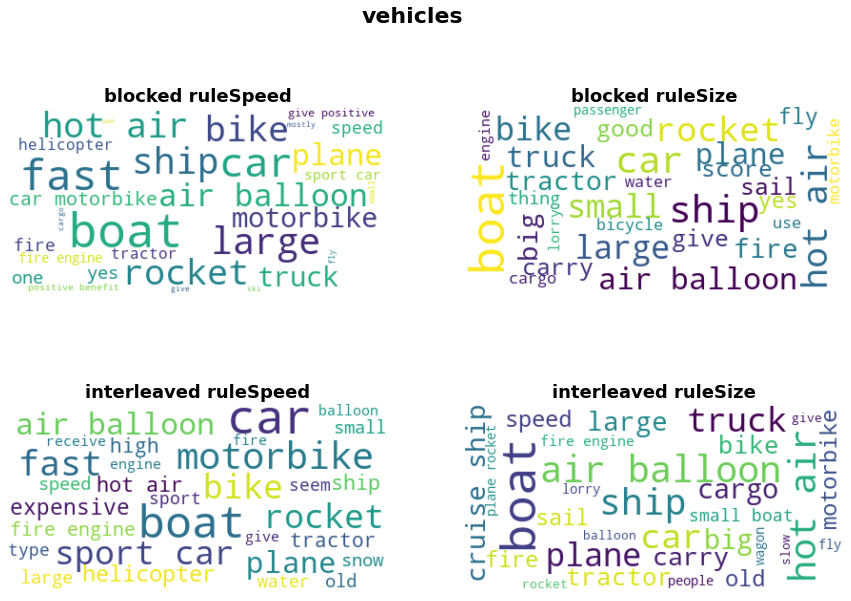

In [33]:

for dom in domains:
    f,ax = plt.subplots(2,2,figsize=(15,10))
    for x,cur in enumerate(curricula):
        for y,rule in enumerate(rules):
            txt = alldata_wc[dom][cur][rule]
            wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white").generate(''.join([' '.join(w) for w in txt]))
            # wordcloud = WordCloud().generate(''.join([' '.join(w) for w in txt]))
            ax[x,y].imshow(wordcloud,interpolation='bilinear')
            ax[x,y].axis('off')
            ax[x,y].set_title(cur + ' ' + rule.split('_')[1],fontsize=18,fontweight='bold')
    plt.suptitle(dom,fontsize=22,fontweight='bold')

In [6]:
# now let's look at the frequency with which terms occur in each task
for dom in domains:
    print(dom + '-----------')
    for cur in curricula:
        print(cur )
        for rule in ['resp_ruleSpeed','resp_ruleSize']:
            print(rule)
            txt_tokenised = alldata_wc[dom][cur][rule]
            txt_flat = [word for sentence in txt_tokenised for word in sentence]
            print(pd.Series(txt_flat).value_counts().sort_values(ascending=False)[:10])

animals-----------
blocked
resp_ruleSpeed
insect     24
try        14
small      14
pattern    13
horse      11
one        11
``         10
big         9
giraffe     9
cat         9
dtype: int64
resp_ruleSize
insect     28
large      20
big        14
small      12
bat        10
one        10
farm        9
mammal      9
dolphin     9
find        8
dtype: int64
interleaved
resp_ruleSpeed
insect       24
bat          18
small        15
water        14
horse        12
creature     12
butterfly    11
fly          11
big          11
giraffe      11
dtype: int64
resp_ruleSize
large     19
big       16
insect    13
exotic    12
seem      10
small      8
cow        8
wild       7
try        7
water      7
dtype: int64
vehicles-----------
blocked
resp_ruleSpeed
car          39
fast         29
boat         28
air          20
motorbike    20
plane        17
large        17
balloon      16
ship         15
fire         14
dtype: int64
resp_ruleSize
boat       34
air        27
car        26
large    

## Topic Modeling with Gensim Latent Dirichlet Allocation
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [6]:
# a few helper functions

def make_dict_and_corpus(txt):
    '''
    generates dictionary, bag of words and word occurence matrix
    input: document with tokenised texts (list of lists)
    '''
    dictionary = gensim.corpora.Dictionary(txt)
    bow_corpus = [dictionary.doc2bow(doc,allow_update=True) for doc in txt]
    id_words = [[(dictionary[id],count) for id,count in line] for line in bow_corpus]
    return dictionary, bow_corpus, id_words


def compute_perplexity(lda_model,corpus):
    return lda_model.log_perplexity(corpus)

def compute_coherence_score(model,txt,dictionary):
    '''
    calculates coherence score.
    score > 0.5 acceptable
    score > 0.7 good
    '''
    coherence_model = CoherenceModel(model=model,texts=txt,dictionary=dictionary,coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence



In [37]:
# concatenate responses for all rules/domains, create domain and rule identifiers
domain_ids = []
rule_ids = []
txt_orig = []
txt_tokenised = []
for dom in domains:
    for cur in curricula:
        for rule in rules:
            txt_orig = txt_orig + alldata[dom][cur][rule]
            txt_tokenised = txt_tokenised + alldata_cleaned[dom][cur][rule]
            n_reports = len(alldata[dom][cur][rule])
            domain_ids = domain_ids + [dom]*n_reports
            rule_ids = rule_ids + [rule.split('rule')[1].lower()]*n_reports



In [8]:
len(txt_orig)

800

Bigrams/Trigrams: Play around with this and check if it improves model performance

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(txt_tokenised, min_count=3, threshold=1) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[txt_tokenised], threshold=1)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


# turn bow into bigrams or trigrams
txt_trigrammed = make_trigrams(txt_tokenised)


### LDA: Hyperparameter tuning

In [ ]:
# # define a few hyperparameters
# n_topics = np.arange(2,22) # don't have a good prior on the number of topics, so let's try a few 


# # instantiate collector variables
# models = [] # store best models (across runs) here
# coherence_scores = []
# perplexity_scores = []


# dictionary, bow_corpus, id_words = make_dict_and_corpus(txt_tokenised)
# for ii,ntop in enumerate(n_topics):
#     print('run ' + str(ii+1) + '/' + str(len(n_topics)))
#     lda_model =  gensim.models.LdaMulticore(bow_corpus, 
#             num_topics = ntop, 
#             id2word = dictionary,                                    
#             passes = 500,
#             workers = 6)
#     perplexity_scores.append(compute_perplexity(lda_model,bow_corpus))
#     coherence_scores.append(compute_coherence_score(lda_model,txt_tokenised,dictionary))
#     models.append(lda_model)
                

                    
# lda_results = {'models':models,
#                 'coherence':coherence_scores,
#                 'perplexity':perplexity_scores,
#                 'n_topics':n_topics}
# with open('lda_results.pkl','wb') as f:
#     pickle.dump(lda_results,f)


# LDA Multicore on whole corpus (concatenated groups): evaluation

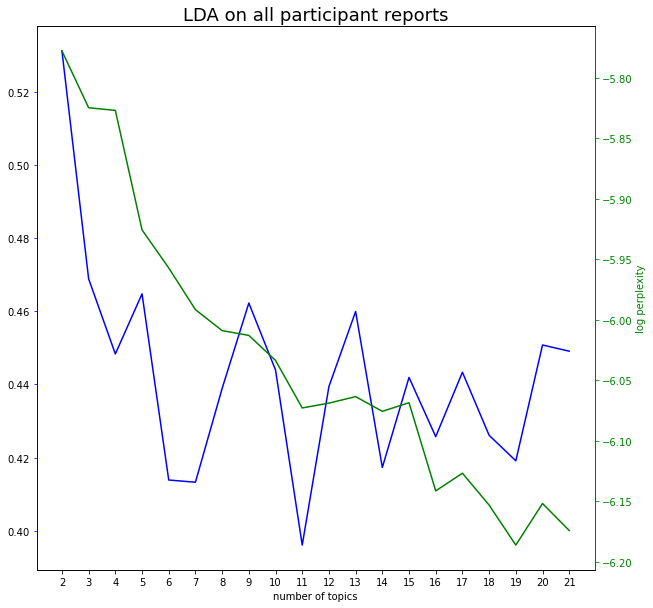

In [38]:
# load results 
with open('lda_results.pkl','rb') as f:
    lda_results = pickle.load(f)
lda_results['models']

# plot perplexity and coherence scores 
f = plt.figure(figsize=(10,10))
ax = plt.gca()
ax.plot(lda_results['coherence'],color='b')
ax.set(xlabel='number of topics')
ax.set_xticks(np.arange(len(lda_results['n_topics'])))
ax.set_xticklabels(lda_results['n_topics'])
ax.yaxis.label.set_color('b')
ax.tick_params(axis='y',color='b')
ax.spines['left'].set_color('b')
ax.set_title('LDA on all participant reports',fontsize=18)
ax2 = ax.twinx()
ax2.plot(lda_results['perplexity'],color='g')
ax2.set_ylabel('log perplexity',color='g')
ax2.yaxis.label.set_color('g')
ax2.tick_params(axis='y', colors='g')
ax2.spines['right'].set_color('g')


coherence suggests 2 topics optimal (animals vs vehicles?). Alternatively perhaps 9 which gives a neat trade-off between coherence scores and log-perplexity...

In [39]:
model_best = lda_results['models'][np.where(lda_results['n_topics']==2)[0][0]]
model_alt = lda_results['models'][np.where(lda_results['n_topics']==9)[0][0]]

## LDA: visualise learned topic distributions

In [40]:
dictionary, bow_corpus, id_words = make_dict_and_corpus(txt_tokenised)
pyLDAvis.enable_notebook()
vis = vis_gensim.prepare(model_best,bow_corpus,dictionary)
vis

PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
0      0.17419  0.0       1        1  50.238729
1     -0.17419  0.0       2        1  49.761271, topic_info=        Term        Freq       Total Category  logprob  loglift
0     animal  337.000000  337.000000  Default  30.0000  30.0000
616  vehicle  214.000000  214.000000  Default  29.0000  29.0000
617     boat  129.000000  129.000000  Default  28.0000  28.0000
626      car  118.000000  118.000000  Default  27.0000  27.0000
61    insect   78.000000   78.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
14     small   42.684319   79.981573   Topic2  -4.4811   0.0700
62     large   42.864359  108.317490   Topic2  -4.4769  -0.2291
65     water   26.238093   43.020440   Topic2  -4.9677   0.2035
123   reject   23.996314   37.738771   Topic2  -5.0570   0.2451
51       fly   21.909294   52.823143   Topic2  -5.1480  -0.1821

[119 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
173       2  0.964055      ``
53        1  0.406703  accept
53        2  0.599888  accept
599       1  0.999502     air
0         2  0.997233  animal
...     ...       ...     ...
16        2  0.968779   whale
146       2  0.942750    wild
101       2  0.953994    wolf
207       1  0.968194     yes
207       2  0.032273     yes

[108 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [31]:
dictionary, bow_corpus, id_words = make_dict_and_corpus(txt_tokenised)
pyLDAvis.enable_notebook()
vis = vis_gensim.prepare(model_alt,bow_corpus,dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.269070 -0.048719       1        1  27.411062
4     -0.123360 -0.215985       2        1  15.513972
3     -0.120387 -0.148390       3        1  14.305049
5      0.098579  0.007767       4        1   9.823724
6      0.267863  0.024382       5        1   8.940198
7     -0.103703  0.114756       6        1   7.013170
8     -0.042508  0.054391       7        1   6.114538
1     -0.152508  0.080329       8        1   6.037467
2     -0.093045  0.131469       9        1   4.840821, topic_info=        Term        Freq       Total Category  logprob  loglift
0     animal  336.000000  336.000000  Default  30.0000  30.0000
616  vehicle  213.000000  213.000000  Default  29.0000  29.0000
617     boat  131.000000  131.000000  Default  28.0000  28.0000
626      car  120.000000  120.000000  Default  27.0000  27.0000
61    insect   78.000000   78.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
8     figure    3.524240   23.107164   Topic9  -4.6451   1.1476
80       etc    3.467279   26.616588   Topic9  -4.6614   0.9899
268     fast    4.071217   61.206091   Topic9  -4.5008   0.3178
634    carry    2.888878   18.528223   Topic9  -4.8439   1.1697
5       blue    3.941914  139.281639   Topic9  -4.5331  -0.5367

[519 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
935       9  0.782724  'always
484       2  0.758629     'big
559       7  0.781538       'd
162       1  0.381750        0
162       7  0.572624        0
...     ...       ...      ...
189       8  0.143573     work
33        3  0.333584    wrong
33        6  0.500377    wrong
207       5  0.971037      yes
112       3  0.963069      zoo

[762 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 6, 7, 8, 9, 2, 3])

In [41]:
dictionary, bow_corpus, id_words = make_dict_and_corpus(txt_tokenised)
pyLDAvis.enable_notebook()
vis = vis_gensim.prepare(lda_results['models'][11],bow_corpus,dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.323386  0.093413       1        1  22.512115
8     -0.265915  0.092598       2        1  14.491151
6      0.111878  0.240083       3        1  12.638901
7      0.115844  0.134720       4        1   8.915762
12     0.122323  0.034537       5        1   6.832729
0      0.065366  0.044081       6        1   6.335556
10     0.121127  0.015871       7        1   6.024409
2      0.013415 -0.046190       8        1   4.646368
9     -0.012819 -0.117528       9        1   4.139880
5      0.097667 -0.091491      10        1   4.068626
3     -0.037227 -0.179006      11        1   3.182023
4     -0.107555 -0.128947      12        1   3.145510
11     0.099281 -0.092140      13        1   3.066969, topic_info=        Term        Freq       Total Category  logprob  loglift
0     animal  336.000000  336.000000  Default  30.0000  30.0000
616  vehicle  216.000000  216.000000  Default  29.0000  29.0000
68    orange  124.000000  124.000000  Default  28.0000  28.0000
617     boat  133.000000  133.000000  Default  27.0000  27.0000
24       one   45.000000   45.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
12     point    1.917625   33.430946  Topic13  -4.7973   0.6261
79   dolphin    1.814229   19.217798  Topic13  -4.8527   1.1243
251     seem    1.703324   56.242976  Topic13  -4.9158  -0.0126
23    memory    1.703318   10.242189  Topic13  -4.9158   1.6905
46   neutral    1.703315    7.744908  Topic13  -4.9158   1.9700

[722 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
935       4  0.752680  'always
484       4  0.752667     'big
559       9  0.781379       'd
451      10  0.586171  'exotic
848      11  0.588550      've
...     ...       ...      ...
207      12  0.668779      yes
453      10  0.586166     zide
112       3  0.865917      zoo
112       5  0.096213      zoo
526      12  0.591346        ’

[1111 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 7, 8, 13, 1, 11, 3, 10, 6, 4, 5, 12])

### LDA: Top 3 most representative sentences per topic

In [12]:
# # load data 
# with open('animals_vehicles_pilot.pkl','rb') as f:
#     alldata = pickle.load(f)
# txt_orig = alldata['vehicles']['blocked']['resp_ruleSize']
# txt_tokenised = alldata_cleaned['vehicles']['blocked']['resp_ruleSize']
# dictionary, bow_corpus, id_words = make_dict_and_corpus(txt_tokenised)
# lda_model = lda_results['best_model']['vehicles']['blocked']['resp_ruleSize']


In [42]:
# each sentence is modelled as weighed composition of the estimated latent topics
# The topic with the strongest weight captures the main topic of that sentence
# We can turn this around and ask which sentences are most representative of each topic
# To do so, we assign each sentence to its dominant topic. We then sort the list of sentences by their topic weight
# The top n sentences are then most representative of the topic
def get_dominant_topics(bow_corpus,lda_model):
    df = pd.DataFrame()
    # get the topic weights for each sentence in the document
    for weights_per_sentence in lda_model[bow_corpus]:
        # sort them by the weight
        weights_per_sentence = sorted(weights_per_sentence,key=lambda x: (x[1]),reverse=True)
        # get dominant topic:
        topic_id = weights_per_sentence[0][0]
        topic_weight = weights_per_sentence[0][1]
        dominant_topic = lda_model.show_topic(topic_id)
        # extract keywords, drop their probabilities
        topic_keywords = ", ".join([w for w, p in dominant_topic])
        df = df.append(pd.Series([topic_id,round(topic_weight,3),topic_keywords]),ignore_index=True)
    # add original (unprocessed) text
    txt = pd.Series(txt_orig)
    df = pd.concat([df,txt],axis=1)
    # add domain and rule identifiers
    doms = pd.Series(domain_ids)
    rules = pd.Series(rule_ids)
    df = pd.concat([df,doms,rules],axis=1)
    df.columns = ['Dominant Topic (ID)', 'Topic Weight', 'Key Words', 'Report','Domain','Rule']
    df.reset_index()
    return df
df = get_dominant_topics(bow_corpus,model_alt)
df.head(120)


,Dominant Topic (ID),Topic Weight,Key Words,Report,Domain,Rule
0,7.0,0.452,"rule, store, think, remember, animal, try, str...",whether or not they were a jungle animal and i...,animals,speed
1,4.0,0.681,"animal, blue, orange, big, insect, store, bat,...","For the blue store, I figured that it was main...",animals,speed
2,7.0,0.822,"rule, store, think, remember, animal, try, str...",couldn't figure out the rule for this store ju...,animals,speed
3,7.0,0.951,"rule, store, think, remember, animal, try, str...",i honestly just went by memory from the practi...,animals,speed
4,3.0,0.704,"animal, insect, large, small, accept, store, s...",small animals,animals,speed
...,...,...,...,...,...,...
115,4.0,0.618,"animal, blue, orange, big, insect, store, bat,...",Mainly trail and error but started by trying l...,animals,size
116,4.0,0.756,"animal, blue, orange, big, insect, store, bat,...",I felt like here I got a reward if I accepted ...,animals,size
117,4.0,0.754,"animal, blue, orange, big, insect, store, bat,...",dolphin pig horse cheeta cow elephant rhino wo...,animals,size
118,3.0,0.528,"animal, insect, large, small, accept, store, s...",a large mammal got points,animals,size


In [43]:
df_grouped = df.groupby(['Dominant Topic (ID)']).apply(lambda x: x.sort_values('Topic Weight',ascending=False))
df_grouped

Dominant Topic (ID)  Topic Weight  \
Dominant Topic (ID)                                          
0.0                 632                  0.0         0.984   
                    435                  0.0         0.981   
                    535                  0.0         0.970   
                    549                  0.0         0.968   
                    663                  0.0         0.968   
...                                      ...           ...   
8.0                 53                   8.0         0.423   
                    167                  8.0         0.422   
                    548                  8.0         0.410   
                    612                  8.0         0.406   
                    199                  8.0         0.370   

                                                                 Key Words  \
Dominant Topic (ID)                                                          
0.0                 632  vehicle, boat, car, balloon, air, ship, plane,...   
                    435  vehicle, boat, car, balloon, air, ship, plane,...   
                    535  vehicle, boat, car, balloon, air, ship, plane,...   
                    549  vehicle, boat, car, balloon, air, ship, plane,...   
                    663  vehicle, boat, car, balloon, air, ship, plane,...   
...                                                                    ...   
8.0                 53   seem, vehicle, high, animal, reward, one, acce...   
                    167  seem, vehicle, high, animal, reward, one, acce...   
                    548  seem, vehicle, high, animal, reward, one, acce...   
                    612  seem, vehicle, high, animal, reward, one, acce...   
                    199  seem, vehicle, high, animal, reward, one, acce...   

                                                                    Report  \
Dominant Topic (ID)                                                          
0.0                 632  Any vehicle that could fly generally received ...   
                    435  Small powered boats gave positive benefits\nFa...   
                    535  Large ships, planes, jets and rockets gave pos...   
                    549  hot air balloons were good, as were big boats,...   
                    663  What type of vehicle has been shown in front o...   
...                                                                    ...   
8.0                 53    Whether or not the animals were vermin or pests.   
                    167           Rhinos were good. \nSheep were neutral.    
                    548  Accepting the vehicles that would appeal to mo...   
                    612  The higher end / possily higher value vehicles...   
                    199                             the size of the anumal   

                           Domain   Rule  
Dominant Topic (ID)                       
0.0                 632  vehicles  speed  
                    435  vehicles  speed  
                    535  vehicles   size  
                    549  vehicles   size  
                    663  vehicles  speed  
...                           ...    ...  
8.0                 53    animals  speed  
                    167   animals   size  
                    548  vehicles   size  
                    612  vehicles  speed  
                    199   animals   size  

[800 rows x 6 columns]

In [17]:
top_sentences = []
counts_per_topic = []
for _,grp in df.groupby(['Dominant Topic (ID)']):
    # get top 3 reports
    top3= grp.sort_values('Topic Weight',ascending=False).head(6)['Report'].to_list()
    top_sentences.append(top3)
    counts_per_topic.append(len(grp))
    

In [46]:
# let's do this for each combination of domain and rule: look at the top most representative keywords & sentences for each topic (and store topic weights for those)
df.groupby(['Domain','Rule','Dominant Topic (ID)']).apply(lambda x: x.sort_values('Topic Weight',ascending=False)).head(20)

Dominant Topic (ID)  Topic Weight  \
Domain  Rule Dominant Topic (ID)                                          
animals size 0.0                 328                  0.0         0.632   
                                 366                  0.0         0.528   
                                 192                  0.0         0.516   
                                 100                  0.0         0.111   
                                 120                  0.0         0.111   
                                 147                  0.0         0.111   
                                 355                  0.0         0.111   
                                 358                  0.0         0.111   
                                 375                  0.0         0.111   
             1.0                 138                  1.0         0.977   
                                 303                  1.0         0.822   
                                 168                  1.0         0.778   
                                 148                  1.0         0.604   
                                 317                  1.0         0.537   
                                 162                  1.0         0.467   
                                 179                  1.0         0.444   
                                 175                  1.0         0.336   
             2.0                 177                  2.0         0.919   
                                 312                  2.0         0.901   
                                 307                  2.0         0.822   

                                                                              Key Words  \
Domain  Rule Dominant Topic (ID)                                                          
animals size 0.0                 328  vehicle, boat, car, balloon, air, ship, plane,...   
                                 366  vehicle, boat, car, balloon, air, ship, plane,...   
                                 192  vehicle, boat, car, balloon, air, ship, plane,...   
                                 100  vehicle, boat, car, balloon, air, ship, plane,...   
                                 120  vehicle, boat, car, balloon, air, ship, plane,...   
                                 147  vehicle, boat, car, balloon, air, ship, plane,...   
                                 355  vehicle, boat, car, balloon, air, ship, plane,...   
                                 358  vehicle, boat, car, balloon, air, ship, plane,...   
                                 375  vehicle, boat, car, balloon, air, ship, plane,...   
             1.0                 138  animal, pattern, find, ``, think, reward, sort...   
                                 303  animal, pattern, find, ``, think, reward, sort...   
                                 168  animal, pattern, find, ``, think, reward, sort...   
                                 148  animal, pattern, find, ``, think, reward, sort...   
                                 317  animal, pattern, find, ``, think, reward, sort...   
                                 162  animal, pattern, find, ``, think, reward, sort...   
                                 179  animal, pattern, find, ``, think, reward, sort...   
                                 175  animal, pattern, find, ``, think, reward, sort...   
             2.0                 177  point, animal, feature, seem, try, item, remem...   
                                 312  point, animal, feature, seem, try, item, remem...   
                                 307  point, animal, feature, seem, try, item, remem...   

                                                                                 Report  \
Domain  Rule Dominant Topic (ID)                                                          
animals size 0.0                 328  Orange seemed to like anything that was big or...   
                                 366                           green for yes red for no   
                    

In [113]:
## above was just scratchpad, now let's run this on all domains, curricula and rules
inferred_topics = {}
with open('animals_vehicles_pilot.pkl','rb') as f:
    alldata = pickle.load(f)

for dom in domains:
    inferred_topics[dom] = {}
    for cur in curricula:
        inferred_topics[dom][cur] = {}
        for rule in rules:
            inferred_topics[dom][cur][rule] = {}
            txt_orig = alldata[dom][cur][rule]
            txt_tokenised = alldata_cleaned[dom][cur][rule]
            dictionary, bow_corpus, id_words = make_dict_and_corpus(txt_tokenised)
            lda_model = lda_results['best_model'][dom][cur][rule]
            df = get_dominant_topics(bow_corpus,lda_model)
            # get list with dominant topic id per subject 
            dom_topics = df['Dominant Topic (ID)'].to_numpy()
            # get list with top sentences per topic and topic count
            top_sentences = []
            counts_per_topic = []
            for _,grp in df.groupby(['Dominant Topic (ID)']):
                # get top 3 reports
                top3= grp.sort_values('Topic Weight',ascending=False).head(3)['Report'].to_list()
                top_sentences.append(top3)
                counts_per_topic.append(len(grp))
            inferred_topics[dom][cur][rule]['dominant_topics'] = dom_topics
            inferred_topics[dom][cur][rule]['top_sentences'] = top_sentences

### LDA: Link with performance. bar plot with average accuracy per 'topic': Are there alternative strategies?

In [ ]:
def compute_acc_per_topic(data,topics,rule_id):
    # compute accuracy per subject:
    testtrials = data['expt_session']==2
    task_trials = data['expt_context']==(rule_id+1)
    accs=[]    
    for ii in range(testtrials.shape[0]):
        accs.append(np.nanmean(data['resp_correct'][ii,testtrials[ii,:]&task_trials[ii,:]]))
    # allocate accs to topics
    accs = np.asarray(accs)
    # sub_ids = np.arange(0,len(accs))
    accs_per_topic = []
    for top_id in np.sort(np.unique(topics)):
        # print(top_id)
        accs_per_topic.append(accs[topics==top_id])
    return accs_per_topic

def disp_acc_per_topic(alldata,inferred_topics):
    '''
    subplots: histogram of topics, accuracy per topic
    
    '''
    sem = lambda x: np.std(x,ddof=1) / np.sqrt(np.size(x))
    for dom in domains:
        for cur in curricula:
            for idx,rule in enumerate(rules):
                # print('## '+ dom + ' - ' + cur + ': ' + rule + ':')
                f,ax = plt.subplots(1,2,figsize=(8,5))
                ax = ax.ravel()
                # histogram of topics
                ax[0].hist(inferred_topics[dom][cur][rule]['dominant_topics'])
                ax[0].set(xlabel='Topic ID',ylabel='number of participants',title='distribution of topics')#,xticks=np.arange(0,4),xticklabels=np.arange(1,5))
                acc_per_topic = compute_acc_per_topic(alldata[dom][cur],inferred_topics[dom][cur][rule]['dominant_topics'],idx)
                for ii,accs in enumerate(acc_per_topic):
                    if len(accs) > 1:
                        ax[1].bar(ii,np.mean(accs),yerr=sem(accs),color='lightgreen')
                    else:
                        ax[1].bar(ii,np.mean(accs),color='lightgreen')
                    ax[1].set(xlabel='Topic ID',ylabel='avg accuracy',title='accuracy per topic')#,xticks=np.arange(0,4),xticklabels=np.arange(1,5))
                plt.suptitle(dom + ' - ' + cur + ': ' + rule,fontweight='bold' )
                plt.tight_layout()


def disp_topics(inferred_topics):
    '''
    prints most representative example sentences for each topic
    '''
    for dom in domains:
        for cur in curricula:
            for idx,rule in enumerate(rules):
                print('## '+ dom + ' - ' + cur + ': ' + rule + ':')                
                # show sentences
                for ii,sentences in enumerate(inferred_topics[dom][cur][rule]['top_sentences']):
                    print('### Topic ' + str(ii) + ':')
                    for sentence in sentences:
                        print('- ' + sentence.replace('\n','. '))
                print('\n')

# disp_topics(inferred_topics)
disp_acc_per_topic(alldata,inferred_topics)

# Topic Modeling with NMF

* import raw text
* concatenate reports from all groups 
* preprocessing 
* tfidf matrix 
* nmf hp search with different n_topics 
* divide results by domain/rule
* most representative sentences and keywords